In [1]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import torch

from dLDS_continuous import dLDS_continuous, fit_dLDS
from utils import solve_trajectory, get_dynamics_on_grid, rotation_matrix, plot_3D_dictionary, plot_interpolation_base

/Users/yenho/miniconda3/envs/pt/lib/python3.8/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/yenho/miniconda3/envs/pt/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


/Users/yenho/Documents/Georgia Tech/SIP lab/neurips/supplementary/utils.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i = torch.matrix_exp(torch.tensor(A, dtype=torch.float) * t) # solution to LDS is the matrix exponential


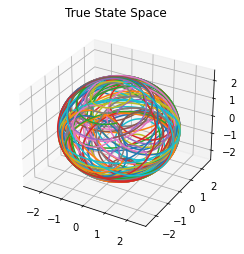

In [2]:
# Ground truth generation

# A = torch.tensor([[0,1,0],[-1.0,0,0],[0,0,0]]).float() # circle
# A = torch.tensor([[-0.3,1,0],[-1,-1.0,0],[0,0,0]]).float() #  spiral
# A = torch.tensor([[1,0,0],[-1,-1.0,0],[0,0,0]]).float()*0.1 # saddle?
# A = torch.tensor([[-1,0,0],[0,-1.0,0],[0,0,0]]).float() # line attractor
# A = torch.tensor([[0,0,0],[0,-1.0,0],[0,0,0]]).float() # plane attractor

# generate data with random rotations

A = torch.tensor([[0,1,0],[-1.0,0,0],[0,0,0]]).float() # circle

n_samples = 100

x0 = npr.randn(3)
DATA = []
for i in range(n_samples):
    R = torch.tensor(rotation_matrix(npr.rand()*np.pi/2)).float()
    G = R @ A @ R.T

    
    T = np.linspace(0, 5, 101)
    x = solve_trajectory(G, x0, T)
    x0 = x[-1]
    DATA.append(x)


    
plt.figure()
ax = plt.axes(projection='3d')
for x in DATA:
    ax.plot(*x.T)
    
plt.title('True State Space')
plt.show()



In [3]:
#  starting points for traces
mins = [-1, -1, -1]
maxs = [1, 1, 1]
X, dXdt = get_dynamics_on_grid(A, mins, maxs, step=2)
x, y, z = X
x = x.flatten()
y = y.flatten()
z = z.flatten()
s = np.c_[x, y, z]

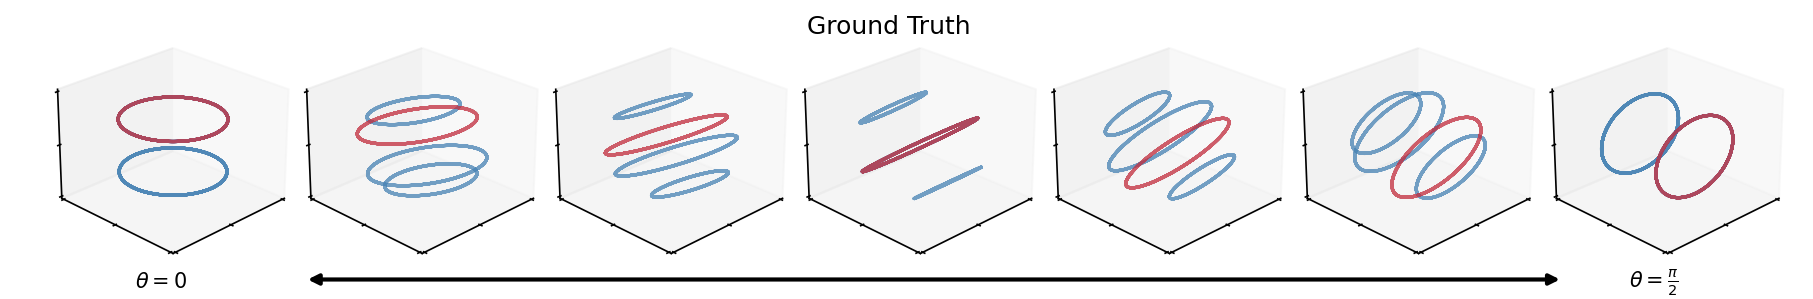

In [4]:
# Plot ground truth continuum 
T_pred = np.linspace(0, 50, 501)
n_plots = 7

fig, axs = plot_interpolation_base('Ground Truth',T_pred)
thetas = np.linspace(0,np.pi/2,n_plots)

for i in range(n_plots):
    theta = thetas[i]
    R = torch.tensor(rotation_matrix(theta)).float()
    G = R @ A @ R.T
    
    for x0 in s[:-1]:
        operator_path = solve_trajectory(G.numpy(), x0, T_pred) 
        axs[i].plot(*operator_path.T, 'steelblue', alpha=0.5)
         
    x0 = s[-1]
    operator_path = solve_trajectory(G.numpy(), x0, T_pred) 
    axs[i].plot(*operator_path.T, 'red', alpha=0.5)
axs[0].text(0.5, -1, -6, r'$\theta=0$', None)
axs[-1].text(0.5, -1, -6, r'$\theta = \frac{\pi}{2}$', None)

plt.show()


## dLDS

In [5]:
z0 = torch.tensor(np.concatenate(DATA)[:-1]).float()
z1 = torch.tensor(np.concatenate(DATA)[1:]).float()

In [6]:
device = 'cpu'


M = 4 # n dictionary elements
N = 3 # dim of latent space


dLDS = dLDS_continuous(M, N)

In [7]:
G_lr = 5e-3
zeta = 8e-2
weight_decay=20

fit_dLDS(dLDS, z0, z1, G_lr=G_lr, zeta=zeta, weight_decay=weight_decay)




Epoch	Loss		Time
0	1.885735	3.890033
1	1.799763	3.915524
2	1.657937	3.572507
3	1.510171	3.589848
4	1.308669	3.386872
5	1.483245	3.506461
6	2.227128	3.674928
7	2.104422	3.501745
8	1.879678	3.624723
9	1.345658	3.895348
10	0.927732	3.684134
11	0.836107	3.652830
12	0.842830	3.714345
13	0.823148	3.622987
14	0.841472	3.430583
15	0.908697	3.482945
16	0.955135	3.567276
17	0.971038	3.606555
18	0.974339	4.019446
19	0.977896	3.977897
20	0.979725	4.266610
21	0.978349	4.577869
22	0.983263	4.384234
23	0.994430	4.571431
24	0.994154	4.167668
25	0.994340	3.952566
26	1.001136	3.984091
27	1.000983	3.934258
28	1.007945	3.930666
29	1.010028	3.861946
30	1.016206	3.925997
31	1.016775	4.115678
32	1.010707	3.969421
33	1.013736	3.879695
34	1.012602	3.866631
35	1.013348	3.878974
36	1.006078	4.031386
37	1.006594	3.914435
38	1.004270	3.403717
39	1.006629	3.474129
40	1.007924	3.543372
41	1.005777	3.322214
42	1.010433	3.322856
43	1.008154	3.411740
44	1.002398	3.234747
45	1.006977	3.216708
46	1.007168	3.646509
47	1.0

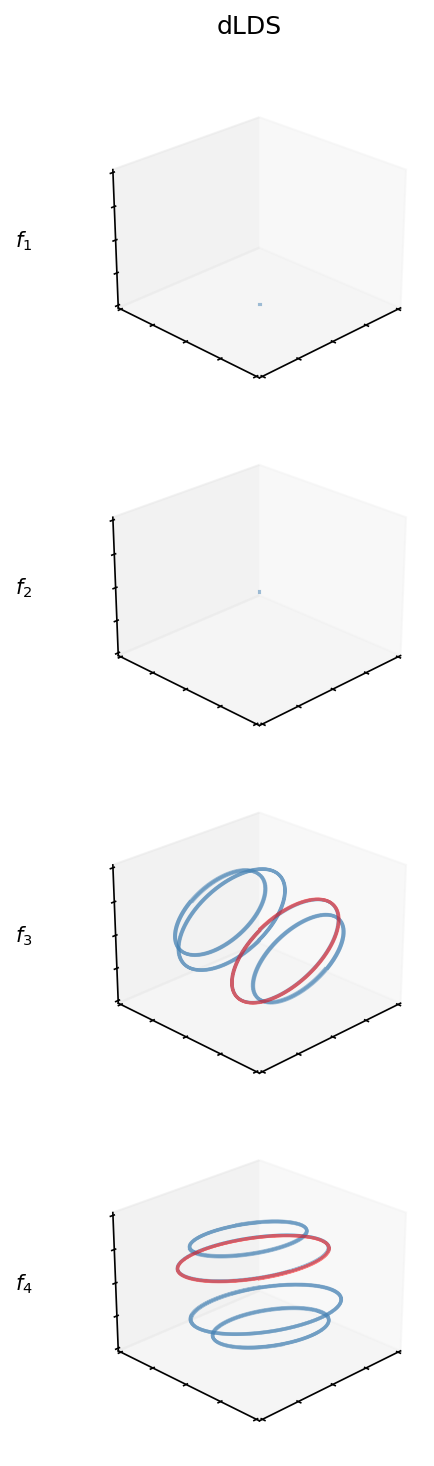

In [8]:
title = 'dLDS'
rslds = False

plot_3D_dictionary(dLDS.get_G(), [np.zeros(3)]*M, s, title, rslds)

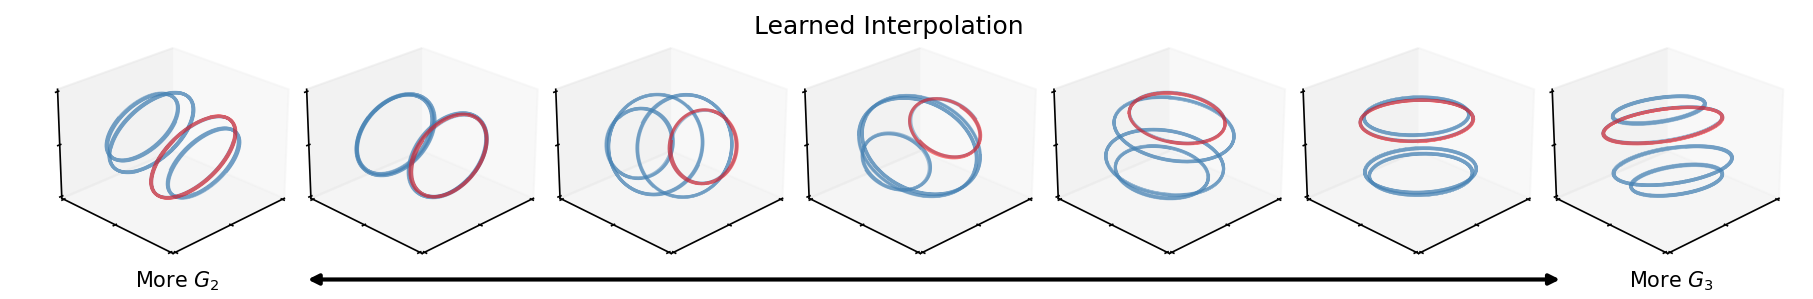

In [9]:
# idx1 = 1 # non-zero dictionary element 1
# idx2 = 3 # non-zero dictionary element 2

sorted_norm = torch.norm(dLDS.get_G(), dim=(1,2)).sort(descending=True)
idx1 = torch.where(sorted_norm.indices == 0)[0][0].numpy()
idx2 = torch.where(sorted_norm.indices == 1)[0][0].numpy()

psi1 = dLDS.get_G()[idx1]
psi2 = dLDS.get_G()[idx2]

cs = np.linspace(0,1,n_plots) # convex combination of two operators

n_plots = 7
T_pred = np.linspace(0, 50, 501)
fig, axs = plot_interpolation_base('Learned Interpolation', T_pred)

for i in range(n_plots):
    c = cs[i]
    psi = (1-c)*psi1 + c*psi2

    for x0 in s[:-1]:
        operator_path = solve_trajectory(psi.numpy(), x0, T_pred) 
        axs[i].plot(*operator_path.T, 'steelblue', alpha=0.5)

    x0 = s[-1]
    operator_path = solve_trajectory(psi.numpy(), x0, T_pred) 
    axs[i].plot(*operator_path.T, 'red', alpha=0.5)

axs[0].text(0.5, -1, -6, rf'More $G_{idx1}$', None)
axs[-1].text(0.5, -1, -6, rf'More $G_{idx2}$', None)
plt.show()

## rSLDS

In [10]:
import ssm

data = np.concatenate(DATA)

n_disc_states = 4
latent_dim = 3         # number of latent dimensions
emissions_dim = 3     # number of observed dimensions

print("Fitting SLDS with Laplace-EM")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, 
                n_disc_states, 
                latent_dim, 
                emissions="gaussian_id", 
                transitions='recurrent_only')


# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=200)

Fitting SLDS with Laplace-EM


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

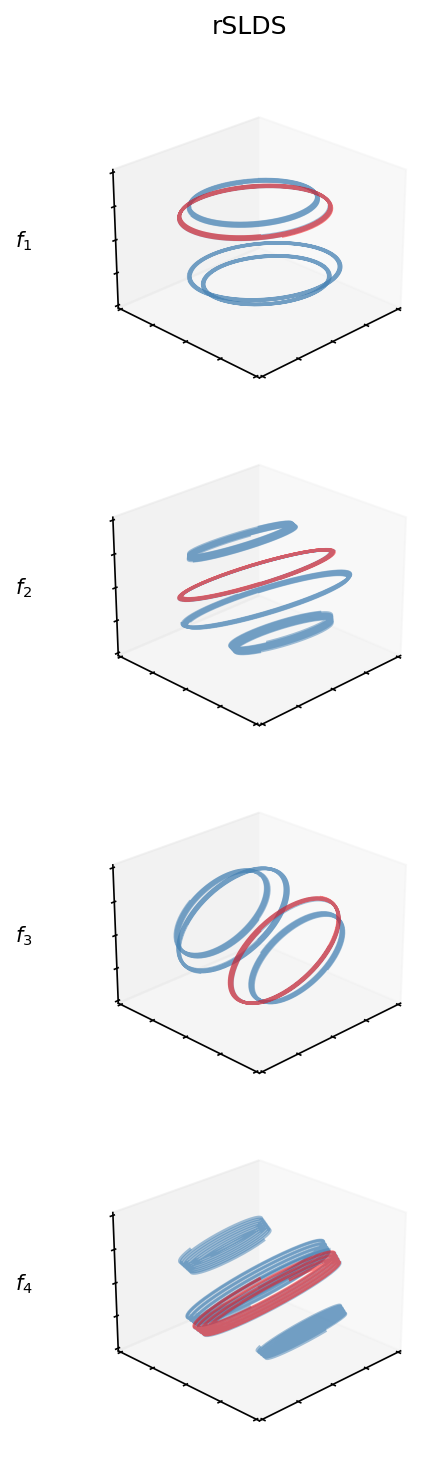

In [11]:
title = 'rSLDS'
rslds = True

plot_3D_dictionary(slds.dynamics.As, slds.dynamics.bs, s, title, rslds)
